# Laboratorium 4 - segmentacje

## Przygotowanie

 * pobierz i wypakuj dataset: https://data.world/socialmediadata/beeradvocate
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab4`
 * zainstaluj potrzebne biblioteki:
 `pip install gensim==3.8.3 wordcloud==1.8.1`

In [1]:
!pip install gensim==3.8.3 wordcloud==1.8.1

## Część 1. - przygotowanie danych

In [2]:
# importujemy potrzebne pakiety

from collections import Counter, defaultdict
import codecs
import csv

from gensim.corpora import Dictionary
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from wordcloud import WordCloud

In [3]:
PATH = 'beer_reviews.csv'
SCORE_THRESHOLD = 4 # recenzje z co najmniej taka ocena wezmiemy pod uwage
VECTOR_SIZE = 20 # jak dlugie powinny byc wektory osadzen uzytkownikow
SEGMENTS_COUNT = 10 # na ile segmentow chcemy podzielic populacje uzytkownikow

In [4]:
# wczytujemy dane

def parse_headers(column_names):
    beer_id_column =  column_names.index('beer_beerid')
    beer_style_column = column_names.index('beer_style')
    user_id_column =  column_names.index('review_profilename')
    score_column =  column_names.index('review_overall')
    return beer_id_column, beer_style_column, user_id_column, score_column


def parse_review(line, beer_id_column, beer_style_column, user_id_column, score_column):
    return line[beer_id_column], line[beer_style_column], line[user_id_column], float(line[score_column])

def read_and_parse_reviews(path, score_threshold):
    with codecs.open(PATH, 'r', 'UTF-8') as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(next(datareader))
    
        users_favourite_beers = defaultdict(list)
        for review in datareader:
            beer_id, _, user_id, score = parse_review(review, beer_id_column, beer_style_column, user_id_column, score_column)
            if score >= score_threshold:
                users_favourite_beers[user_id].append(beer_id)

    return users_favourite_beers

def get_beer_id_to_style_mapping(path):
    with codecs.open(PATH, 'r', 'UTF-8') as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(next(datareader))
        beer_styles = {}
        for review in datareader:
            beer_id, beer_style, _, _ = parse_review(review, beer_id_column, beer_style_column, user_id_column, score_column)
            beer_styles[beer_id] = beer_style
        return beer_styles

# otrzymujemy slownik - mapowanie z user_id na liste ulubionych beer_ids
users_favourite_beers = read_and_parse_reviews(PATH, SCORE_THRESHOLD)

# dodatkowo przygotujmy sobie slownik mapujacy id piwa na nazwe stylu
beer_styles = get_beer_id_to_style_mapping(PATH)

## Część 2. - osadzenia użytkowników

In [5]:
# trenujemy model osadzajacy piwa i uzytkownikow w przestrzeni

model = Word2Vec(sentences=users_favourite_beers.values(), size=VECTOR_SIZE, window=5, min_count=1, workers=4)

In [6]:
print(model.wv['3'])

[ 2.2222273e-01  1.1288734e-01 -1.8639755e-01 -1.3185014e-01
  1.1226042e-01  6.0607843e-02  1.5604498e-02  8.3403766e-02
 -1.3573714e-01  2.2012913e-01  1.0215200e-01 -1.0816533e-01
  1.2618041e-02 -4.7748860e-02  4.8131678e-02  3.9943490e-02
  3.8812887e-02 -7.5331517e-02 -8.8209836e-03  1.7411137e-04]


In [7]:
!python3 --version

Python 3.8.10


In [8]:
# na podstawie modelu obliczamy wektorowa reprezentacje uzytkownikow

def get_mean_vector_for_user(user_favourite_beers, model, vector_size):
    # inicjalizujemy wektor zerami
    v = np.zeros(vector_size)
    
    for beer_id in user_favourite_beers:
        v += model.wv[beer_id]

    
    if len(user_favourite_beers) > 0:
        return (v / len(user_favourite_beers))
    else:
        return 0
    
#     if len(user_favourite_beers) == 0:
#         print("zero")
    
    
    
    
    # iterujemy po liscie user_favourite_beers, odczytujemy z modelu wektor reprezentujacy kazde piwo i dodajemy do wektora
    #   uzyj: model.wv[beer_id]
    # ...
    
    # normalizujemy wektor - dzielimy kazda wspolrzedna przez liczbe piw
    # ...


def get_mean_user_vectors(users_favourite_beers, model, vector_size):
    # korzystajac z powyzszej funkcji, tworzymy slownik {user_id -> vector}
    mean_users_vectors = {}
    for user_id, beers in users_favourite_beers.items():
        v = get_mean_vector_for_user(users_favourite_beers[user_id], model, vector_size)
        mean_users_vectors[str(user_id)] = v
        
    return mean_users_vectors

user_vectors = get_mean_user_vectors(users_favourite_beers, model, VECTOR_SIZE)

## Część 3. - klasteryzacja

In [9]:
!pip install sklearn

In [22]:
# klastrujemy uzytkownikow - mozemy uzyc wielu algorytmow, np k-means, agglomerative, BIRCH, ...

def get_users_segmentation(user_vectors, vector_size, segments_count, clustering_algorithm):
    # rozkladamy slownik user_vectors na liste uzytkownikow i liste wektorow
    #  - wazne jest zachowanie tej samej kolejnosci w obu listach
    users = user_vectors.keys()    # ...
    vectors = user_vectors.values()   # ...
    
    # zamieniamy liste wektorow w macierz
    users_array = np.stack(vectors, axis=0)
    # zaimplementuj wsparcie dla co najmniej jednego algorytmu wiecej
    if clustering_algorithm == 'agglomerative':
        clustering = AgglomerativeClustering(n_clusters=segments_count).fit_predict(users_array)
        # clustering to lista przypisanych klastrow - i-ty element to klaster, do ktorego nalezy i-ty wektor
    elif clustering_algorithm == 'k-means':
        clustering = KMeans(n_clusters=segments_count, random_state=0).fit_predict(users_array)
#         clustering = KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
    
    segmentation = {}

#     print(users)

        
    i = 0
    for user in users:
#         print(user)
        segmentation[str(user)] = clustering[i]
        i += 1

    # jesli nie pomieszalismy kolejnosci w listach, to mozemy odzyskac mapping user_id -> cluster
    # ...
    return segmentation

segmentation = get_users_segmentation(user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, 'agglomerative')

/home/magdalena/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
# obliczamy licznosci segmentow

def get_segment_sizes(segmentation):
    segment_sizes = {}
    for i in range(0, 12):
        counter = sum(value == 0 for value in segmentation.values())
        if counter > 0:
            segment_sizes[i] = counter
    return segment_sizes

get_segment_sizes(segmentation)

{0: 986,
 1: 986,
 2: 986,
 3: 986,
 4: 986,
 5: 986,
 6: 986,
 7: 986,
 8: 986,
 9: 986,
 10: 986,
 11: 986}

In [ ]:
print(segmentation)

## Część 4. - opisy segmentów

In [24]:
# obliczamy popularnosc styli w segmentach oraz w calej populacji
#  - czyli jak czesto kazdy ze styli wystepowal

def get_per_segment_styles_popularity(users_favourite_beers, beer_styles, segmentation, segments_count):
    beer_styles_per_segment = {i: defaultdict(lambda: 0) for i in range(segments_count)}
    # do tego slownika bedziemy sie odwolywac np. tak: beer_styles_per_segment[segment][style]
    
    for user, beers in users_favourite_beers.items():
        for beer in beers:
            segment = segmentation[user]
            style = beer_styles[beer]
            beer_styles_per_segment[segment][style] += 1

    return beer_styles_per_segment


def get_total_styles_popularity(beer_styles_per_segment):
    total_popularity = defaultdict(lambda: 0)
    
    for segment in beer_styles_per_segment:
        for style in beer_styles_per_segment[segment]:
            total_popularity[style] += beer_styles_per_segment[segment][style]

    return total_popularity


per_segment_styles_popularity = get_per_segment_styles_popularity(users_favourite_beers, beer_styles, segmentation, SEGMENTS_COUNT)
total_styles_popularity = get_total_styles_popularity(per_segment_styles_popularity)

In [13]:
import operator

In [25]:
# przygotujmy dwa opisy segmentow - top N najpopularniejszych stylow w kazdym segmencie
#   oraz top N unikalnych - to samo, ale popularnosc w segmencie dzielimy przez laczna popularnosc
#   dla potrzeb wizualizacji w nastepnym kroku, zwroc slownik {segment_id -> {style_id -> frequency}}

from operator import itemgetter
def most_popular_styles_per_segment(per_segment_styles_popularity, N):
    result = {}
    style_frequency = {}
    
    print(per_segment_styles_popularity[0])
    
    for segment in range(0, len(per_segment_styles_popularity)):
        print("SEGMENT = " + str(segment))
        print(per_segment_styles_popularity[segment])
        for k,v in per_segment_styles_popularity[segment].items():
            print("beer = " + str(k) + " style = " + str(v))  
            
        n_biggest_in_segment = dict(sorted(per_segment_styles_popularity[segment].items(), key = itemgetter(1), reverse = True)[:N])
        print(n_biggest_in_segment)
        result[segment] = n_biggest_in_segment
        
        
    return result
    
    
    
    
    

def most_distinctive_styles_per_segment(total_styles_popularity, per_segment_styles_popularity, N):
    result = {}
    style_frequency = {}
    
    print(per_segment_styles_popularity[0])
    
    for segment in range(0, len(per_segment_styles_popularity)):
        print("SEGMENT = " + str(segment))
        print(per_segment_styles_popularity[segment])
        for k,v in per_segment_styles_popularity[segment].items():
            print("beer = " + str(k) + " style = " + str(v))  
            
        n_biggest_in_segment = dict(sorted(per_segment_styles_popularity[segment].items(), key = itemgetter(1), reverse = True)[:N])
        print(n_biggest_in_segment) # kazda value / TOTAL
        n_biggest_in_segment.update((x, y / total_styles_popularity[x]) for x, y in n_biggest_in_segment.items())
        result[segment] = n_biggest_in_segment
        
        
    return result
     
top_N = 50
most_popular = most_popular_styles_per_segment(per_segment_styles_popularity, top_N)
most_distinctive = most_distinctive_styles_per_segment(total_styles_popularity, per_segment_styles_popularity, top_N)

defaultdict(<function get_per_segment_styles_popularity.<locals>.<dictcomp>.<lambda> at 0x7f907509b280>, {'Fruit / Vegetable Beer': 1, 'English Barleywine': 13, 'American IPA': 112, 'American Barleywine': 11, 'Old Ale': 11, 'American Stout': 16, 'Belgian Strong Dark Ale': 4, 'Saison / Farmhouse Ale': 20, 'Flanders Red Ale': 8, 'Rauchbier': 1, 'Scottish Gruit / Ancient Herbed Ale': 10, 'Flanders Oud Bruin': 6, 'Oatmeal Stout': 12, 'American Strong Ale': 95, 'American Double / Imperial IPA': 161, 'Winter Warmer': 7, 'Quadrupel (Quad)': 4, 'Belgian Strong Pale Ale': 57, 'Russian Imperial Stout': 63, 'American Amber / Red Ale': 28, 'Dubbel': 12, 'American Pale Lager': 10, 'Hefeweizen': 58, 'Schwarzbier': 15, 'Black & Tan': 4, 'English Pale Ale': 6, 'American Pale Wheat Ale': 30, 'Milk / Sweet Stout': 7, 'Eisbock': 5, 'American Porter': 31, 'Doppelbock': 42, 'Scottish Ale': 4, 'Dunkelweizen': 10, 'Weizenbock': 23, 'English Bitter': 2, 'American Pale Ale (APA)': 14, 'Vienna Lager': 2, 'Ameri

## Część 5. - wizualizacja

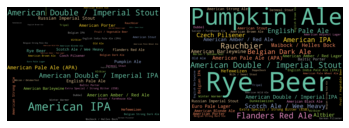

In [21]:
# k-means

# teraz mozemy zwizualizowac nasze segmentacje za pomoca word clouds
#   zauwaz, jak roznia sie obie metody opisow segmentow oraz opisy miedzy poszczegolnymi segmentami

w = 1000
h = 750

def visualise_styles(most_popular, most_distinctive, segment_id):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    wordcloud1 = WordCloud(width = w, height = h, random_state=42, background_color='black', colormap='Set2', collocations=False)
    wordcloud1.generate_from_frequencies(frequencies=most_popular[segment_id])
    ax1.imshow(wordcloud1, interpolation="bilinear")
    wordcloud2 = WordCloud(width = w, height = h, random_state=42, background_color='black', colormap='Set2', collocations=False)
    wordcloud2.generate_from_frequencies(frequencies=most_distinctive[segment_id])
    ax2.imshow(wordcloud2, interpolation="bilinear")
    ax1.axis("off")
    ax2.axis("off")
    plt.show()
    
visualise_styles(most_popular, most_distinctive, 3)

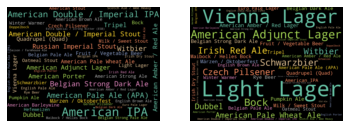

In [26]:
# agglomerative

# teraz mozemy zwizualizowac nasze segmentacje za pomoca word clouds
#   zauwaz, jak roznia sie obie metody opisow segmentow oraz opisy miedzy poszczegolnymi segmentami

w = 1000
h = 750

def visualise_styles(most_popular, most_distinctive, segment_id):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    wordcloud1 = WordCloud(width = w, height = h, random_state=42, background_color='black', colormap='Set2', collocations=False)
    wordcloud1.generate_from_frequencies(frequencies=most_popular[segment_id])
    ax1.imshow(wordcloud1, interpolation="bilinear")
    wordcloud2 = WordCloud(width = w, height = h, random_state=42, background_color='black', colormap='Set2', collocations=False)
    wordcloud2.generate_from_frequencies(frequencies=most_distinctive[segment_id])
    ax2.imshow(wordcloud2, interpolation="bilinear")
    ax1.axis("off")
    ax2.axis("off")
    plt.show()
    
visualise_styles(most_popular, most_distinctive, 3)